In [70]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta, timezone
%matplotlib inline

# Data Wrangling

In [84]:
# Loading Data
df_noshow = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")
df_noshow.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [85]:
# Checking whether the columns meet the datatype
df_noshow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### Fixing column name typo

In [86]:
df_noshow.rename(columns = {"Handcap": "Handicap", "No-show": "No_show", "Hipertension": "Hypertension"}, inplace = True)
df_noshow.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Changing columns data type into a more suitable one

In [87]:
df_noshow["ScheduledDay"] = pd.to_datetime(df_noshow["ScheduledDay"]).dt.tz_localize(None)
df_noshow["AppointmentDay"] = pd.to_datetime(df_noshow["AppointmentDay"]).dt.tz_localize(None)
df_noshow["PatientId"] = df_noshow['PatientId'].astype('int64')

# Turning No_show column values into boolean values
df_noshow["No_show"].replace(('Yes', 'No'), (1,0), inplace = True)
df_noshow["No_show"] = df_noshow["No_show"].astype('bool')

In [101]:
# Truncating the ScheduledDay field to fetch the number of days between appointment and scheduled dates
df_noshow["ScheduledDate"] = df_noshow["ScheduledDay"].dt.date
df_noshow["ScheduledDate"] = pd.to_datetime(df_noshow["ScheduledDate"]).dt.tz_localize(None)
df_noshow["Days_to_appointment"] = (df_noshow['AppointmentDay'] - df_noshow['ScheduledDay']).dt.days
df_noshow.drop(columns = ["ScheduledDate"], inplace = True) 
df_noshow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PatientId            110527 non-null  int64         
 1   AppointmentID        110527 non-null  int64         
 2   Gender               110527 non-null  object        
 3   ScheduledDay         110527 non-null  datetime64[ns]
 4   AppointmentDay       110527 non-null  datetime64[ns]
 5   Age                  110527 non-null  int64         
 6   Neighbourhood        110527 non-null  object        
 7   Scholarship          110527 non-null  int64         
 8   Hypertension         110527 non-null  int64         
 9   Diabetes             110527 non-null  int64         
 10  Alcoholism           110527 non-null  int64         
 11  Handicap             110527 non-null  int64         
 12  SMS_received         110527 non-null  int64         
 13  No_show       

## Creating new columns to help in the further analysis

In [102]:
df_noshow['ScheduledWeekday'] = df_noshow['ScheduledDay'].dt.day_name() # column to get the day of the week   
df_noshow['AppointmentWeekday'] = df_noshow['AppointmentDay'].dt.day_name() #  column to get the day of the week 

In [103]:
df_noshow.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,Days_to_appointment,ScheduledWeekday,AppointmentWeekday
110522,2572134369293,5651768,F,2016-05-03 09:15:35,2016-06-07,56,MARIA ORTIZ,0,0,0,0,0,1,False,34,Tuesday,Tuesday
110523,3596266328735,5650093,F,2016-05-03 07:27:33,2016-06-07,51,MARIA ORTIZ,0,0,0,0,0,1,False,34,Tuesday,Tuesday
110524,15576631729893,5630692,F,2016-04-27 16:03:52,2016-06-07,21,MARIA ORTIZ,0,0,0,0,0,1,False,40,Wednesday,Tuesday
110525,92134931435557,5630323,F,2016-04-27 15:09:23,2016-06-07,38,MARIA ORTIZ,0,0,0,0,0,1,False,40,Wednesday,Tuesday
110526,377511518121127,5629448,F,2016-04-27 13:30:56,2016-06-07,54,MARIA ORTIZ,0,0,0,0,0,1,False,40,Wednesday,Tuesday


In [104]:
# Checking duplicated values
sum(df_noshow.duplicated())

0

In [105]:
# Checking Data details
df_noshow.describe()

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Days_to_appointment
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,9.183702
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,15.254996
min,3.921700e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,14.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,178.000000


# Data Cleaning

In [112]:
# Discarding Negative values for age
df_noshow_clnd = df_noshow.loc[df_noshow['Age']>= 0].copy()
df_noshow_clnd.reset_index(drop = True, inplace = True)
df_noshow_clnd.describe()

,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,Days_to_appointment
count,1.105260e+05,1.105260e+05,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,1.474934e+14,5.675304e+06,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029,9.183794
std,2.560943e+14,7.129544e+04,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874,15.255034
min,3.921700e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000
25%,4.172536e+12,5.640285e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,3.173184e+13,5.680572e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,9.438963e+13,5.725523e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,14.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,178.000000


# Exploring Data

In [107]:
# Checking the proportion between the show and no show cases
no_show_proportion= df_noshow_clnd.query('No_show == True')['AppointmentID'].count()/df_noshow_clnd['AppointmentID'].count()
no_show_proportion

0.20193438647919945

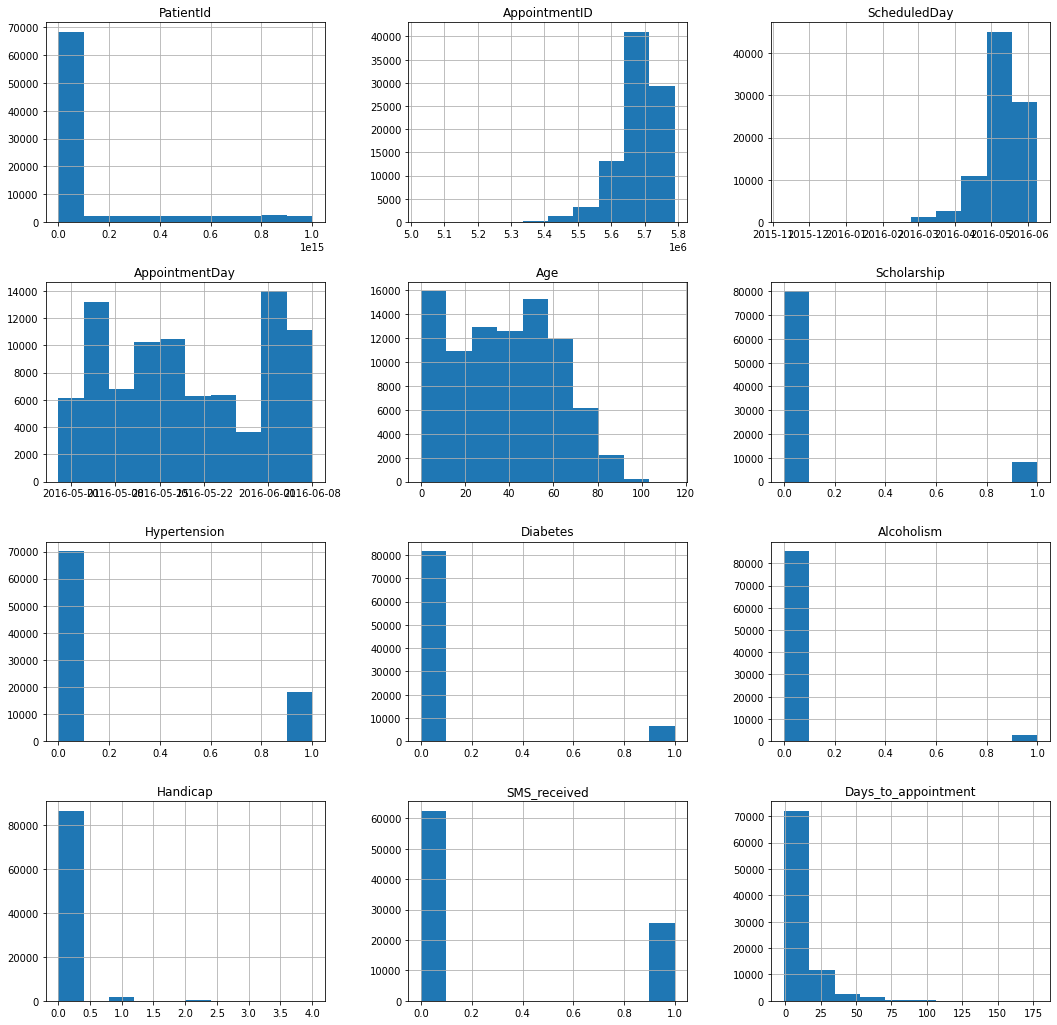

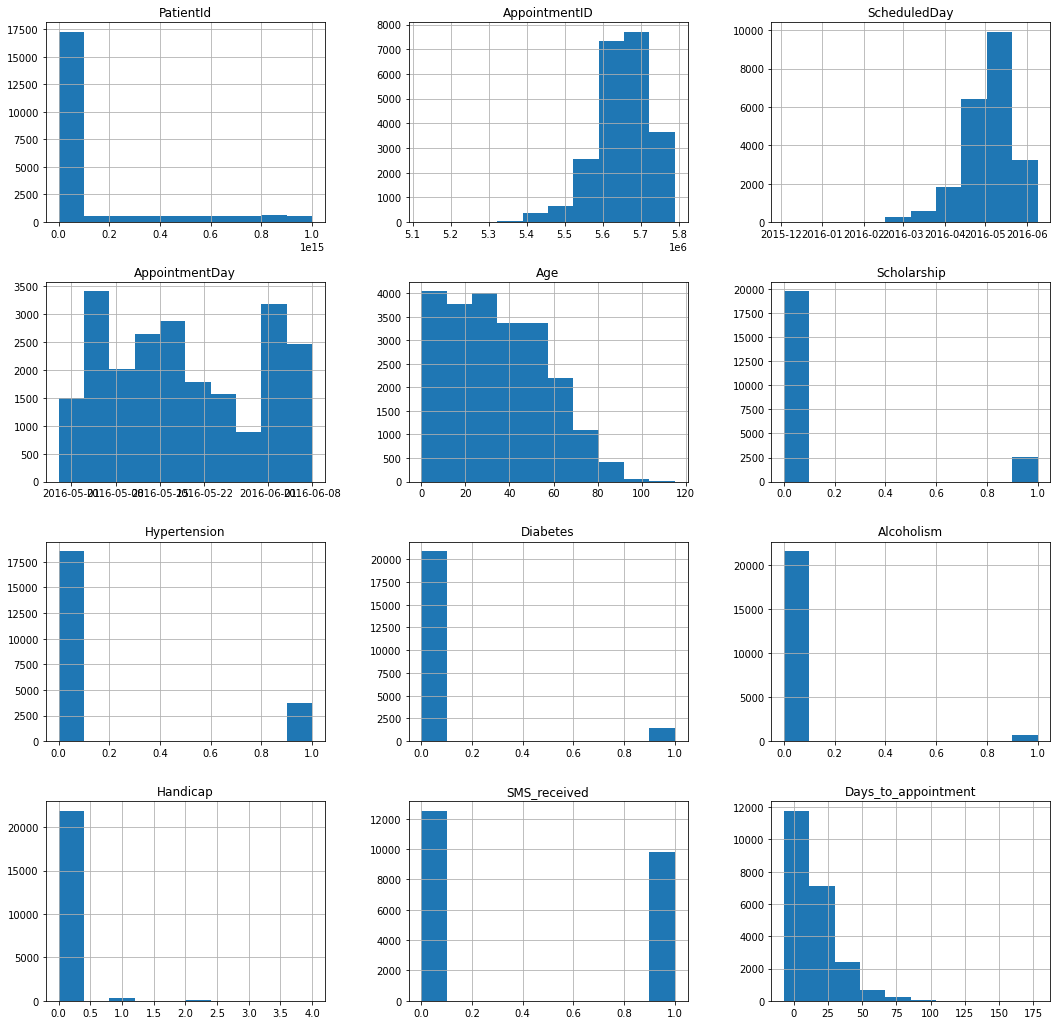

In [108]:
# Binning the Patient Age in groups of 10 years
bin_ages = []
bin_names = 

In [137]:
def binning(min_value, max_value, bin_size):
    # Function to bin the ages in 10 to 10 years
    bin_list = []
    for i in range(min_value, max_value):
        low = min_value
        while low%bin_size != 0:
            low -= 1
        high = max_value
        while high%bin_size != 0:
            high += 1
    for i in range (low, high+1, bin_size):
        bin_list.append(i)
    return bin_list
        
   

In [144]:
bin_ages = binning(min(df_noshow_clnd.Age),max(df_noshow_clnd.Age), 10)
bin_ages

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

In [145]:
def bin_names(bin_list):
    

120